In [1]:
# normal imports
import os, sys, json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile as tf
from matplotlib.backends.backend_pdf import PdfPages

# ignore numpy warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.DtypeWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

lib_dir = "/Users/danielysprague/foco_lab/wb-live/analysis/lib"
npex_dir = "/Users/danielysprague/foco_lab/npex"
resources_dir = "C:/Users/danielysprague/data/wblive-processed-db/resources/"
raw_datadir = "/Users/danielysprague/FOCO_lab/data/NP_Ray/"
module_path = os.path.abspath(os.path.join(lib_dir))
npex_path = os.path.abspath(os.path.join(npex_dir))
if module_path not in sys.path:
    sys.path.append(module_path)
if npex_path not in sys.path:
    sys.path.append(npex_path)

# for debugging and custom classes
import importlib    
import wbliveDataClass
importlib.reload(wbliveDataClass)
import wbliveAggregateDataFunctions
importlib.reload(wbliveAggregateDataFunctions)
import wblivePlotFunctions
importlib.reload(wblivePlotFunctions)
import NeuralStateClassifier
importlib.reload(NeuralStateClassifier)
from useful_scripts import npex_launcher
importlib.reload(npex_launcher)



<module 'useful_scripts.npex_launcher' from '/Users/danielysprague/foco_lab/wb-live/analysis/lib/useful_scripts/npex_launcher.py'>

In [16]:
#fname_root = '20221106-21-47-31'
#fname_root = '20221106-21-23-19'
#fname_root = '20220529-14-16-47'
#fname_root = '20221028-18-48-00'
#fname_root = '20221106-21-00-09'
#fname_root = '20221215-20-02-49'
#fname_root = '20230322-20-16-50'
#fname_root = '20230322-18-57-04'
#fname_root = '20230322-21-41-10'
#fname_root = '20230322-22-43-03'
#fname_root = '20230506-12-56-00'
#fname_root = '20230506-13-32-08'
#fname_root = '20230506-14-24-57'
#fname_root = '20230506-15-01-45'
#fname_root = '20230506-15-33-51'
#fname_root = '20230510-12-53-34'
fname_root = '20230510-13-25-46'
#fname_root = '20230510-15-49-47'
#fname_root = '20230510-16-36-46'
#fname_root = '20221215-22-02-55'
#fname_root = '20230412-20-15-17'


{'f': '/Users/danielysprague/FOCO_lab/data/NP_Ray/20230510-13-25-46/Composite.tif', 'output_folder': '/Users/danielysprague/FOCO_lab/data/NP_Ray/20230510-13-25-46/anl_npe_output', 'rgbw_channels': [0, 1, 2, 3], 'data_tag': '20230510-13-25-46', 'peakfinding_parameters': {'pad': [2, 6, 6], 'median': 5, 'gaussian': (1, 1, 4, 4, 3, 3), 'quantile': 0.985, 'threshold': 0.65, 'peakfind_channel': 4}}
-------- NPExtractor --------
loaded  :  /Users/danielysprague/FOCO_lab/data/NP_Ray/20230510-13-25-46/Composite.tif
made template
found peaks
exported:  /Users/danielysprague/FOCO_lab/data/NP_Ray/20230510-13-25-46/anl_npe_output/npextractor.json
exported:  /Users/danielysprague/FOCO_lab/data/NP_Ray/20230510-13-25-46/anl_npe_output/npextractor.json


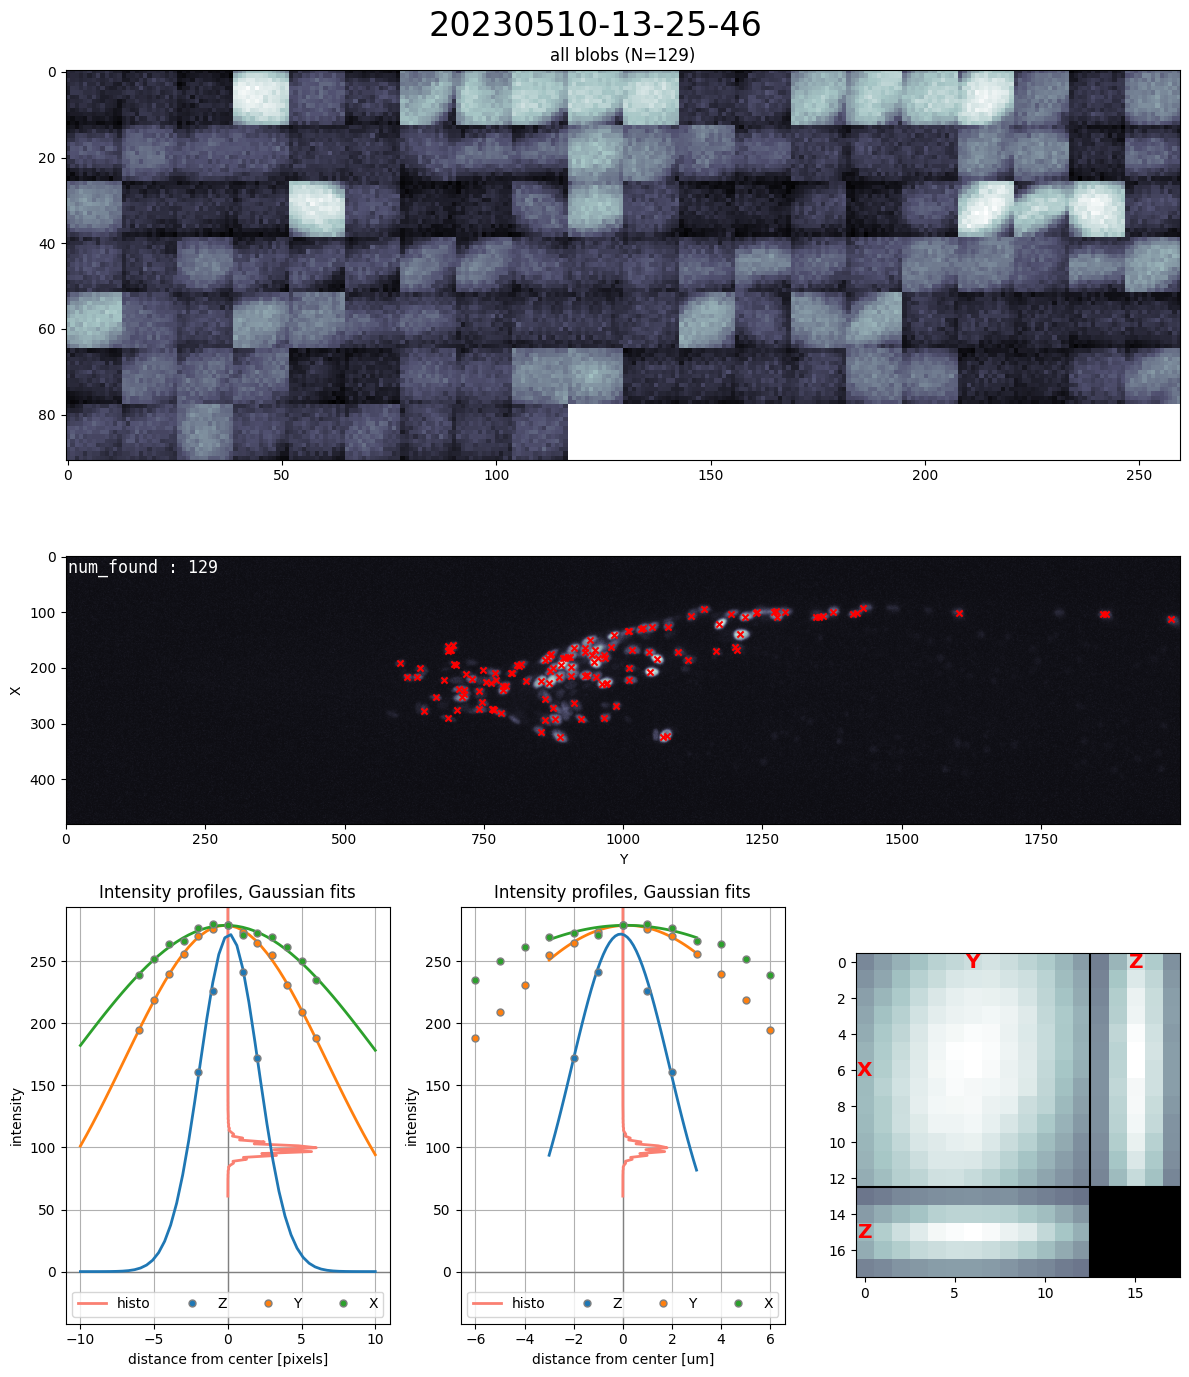

: 

In [17]:
#peakfind_channel = 3 # 488, GFP/GCAMP, 3 for post 20230322
#peakfind_channel = 2 # for pre 20230322
peakfind_channel = 4 #if directly giving composite image as f

# set peakfinding for neuropal

npe_params = {
    "f": raw_datadir+fname_root+"/Composite.tif",
    #"rgbw_channels":[4,2,0,5], #for 20230322 recordings and beyond
    #"rgbw_channels":[3,1,0,4], #for before
    "rgbw_channels":[0,1,2,3], #if directly giving image as f
    "peakfinding_parameters": {
        "pad": [2, 6, 6],
        "median": 5,
        "gaussian":(1, 1, 4, 4, 3, 3),
        #"gaussian":(5,5,4,4,3,3), # for images w/o binning
        #"gaussian":(4, 4, 0.35, 0.35, 2, 0.25),
        #"quantile": 0.96, # for images w/o binning
        "quantile":0.985,
        #"threshold": 0.6, # for images w/o binning
        "threshold": 0.65,
        "peakfind_channel":peakfind_channel
    }
}

# run npex requires fname_root, datadir, npe_params, is_neuropal, is_legacy_structuralscandir, peakfind_channel

npe = npex_launcher.run_npex(fname_root=fname_root, datadir=raw_datadir, npe_params=npe_params, peakfind_channel=peakfind_channel)

In [7]:
import json
f= "/Users/danielsprague/FOCO_lab/data/NP_Ray/"+fname_root+'/tiffreader.json'

with open(f) as jfopen:
    jd = json.load(jfopen)

In [8]:
jd.get('axes', None)

'TCZYX'

In [18]:
suffixes = ['561-700-75m', '488']
adj_x = 15
adj_y = -9

print(os.getcwd())
# do some pathing
structural_scan_dir = '/Users/danielsprague/FOCO_lab/NP_eval/data/NP_Ray/20220529-14-16-47/'
original_images_dir = '/Users/danielsprague/FOCO_lab/NP_eval/data/NP_Ray/20220529-14-16-47/original_offset/'
if not os.path.isdir(original_images_dir):
    os.mkdir(original_images_dir)
else:
    im_sure_flag = False
    if not im_sure_flag:
        raise(Exception('Error: original images directory {} already exists. Are you sure you are not accidentally double-correcting?'))

# iterate images in structural scan directory
cwd = os.getcwd()
os.chdir(structural_scan_dir)
filelist = os.listdir(structural_scan_dir)
for f in filelist:

    # if tiff file, load
    for suffix in suffixes:
        if f.endswith('{}.tiff'.format(suffix)):
            d = tf.imread(f)

            # make new array
            new_d = np.zeros(d.shape, dtype=d.dtype)

            # adjust according to x
            if adj_x > 0:
                new_d[:,:,adj_x:] = d[:,:,:-adj_x]
                new_d[:,:,:adj_x] = d[:,:,:adj_x]
            elif adj_x < 0:
                new_d[:,:,:adj_x] = d[:,:,-adj_x:]
                new_d[:,:,adj_x:] = d[:,:,adj_x:]

            # adjust according to y
            if adj_y > 0:
                new_d[:,adj_y:,:] = d[:,:-adj_y,:]
                new_d[:,:adj_y,:] = d[:, :adj_y,:]
            elif adj_y < 0:
                new_d[:,:adj_y,:] = d[:,-adj_y:,:]
                new_d[:,adj_y:,:] = d[:, adj_y:,:]

            # move old file into new
            tf.imwrite(original_images_dir + f, d)

            # overwrite local old files with adjusted
            tf.imwrite(structural_scan_dir + f, new_d)

# change directory back
os.chdir(cwd)

/Users/danielsprague/FOCO_lab/NP_eval/data/NP_Ray/20220529-14-16-47


In [11]:
print(os.getcwd())

/Users/danielsprague/FOCO_lab/NP_eval/data/NP_Ray/20220529-14-16-47
